<a href="https://colab.research.google.com/github/YuanQi-ME/hello-world/blob/master/Exercise_2_fitting_multiple_to_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
In the previous notebook, we built the single varible to single varible mapping structure through simple ANN. In this notebook, we extend it to multiple inputs to single/multiple input(s).

We will walk through two examples here. In the first case, we will try to solve the partial differential equations. 
In the second case, we will try to predict FEM results.
In both cases, we only consider state variables, which means the physical state is history-independent, for example, the elastic beam problem. For those cases that are history-dependent, such as plastic deformation and viscocity, we will probably revisit those problems in the future notebook using RNN.

# **Case I: PDE**
In this section, we will try to solve PDE
$f_{,xx} + f_{,yy} + 2f = 0$, with boundary condition $f(0,y) = f(x,0) = 0$.
The analytical solution is $f(x,y) = sin(x)sin(y)$

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd

print(tf.__version__)

2.2.0


In [2]:
# Build model structure
def build_model(LAYERS_INFO):
  model = keras.Sequential()
  model.add(keras.layers.Dense(LAYERS_INFO[0], activation = 'relu', input_shape=[x_data_items]))
  for num_ in LAYERS_INFO[1:-1]:
    model.add(keras.layers.Dense(num_, activation = 'relu'))

  model.add(keras.layers.Dense(LAYERS_INFO[-1]))

  optimizer = keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer = 'adam', metrics=['accuracy'])

  return model

#  
x_data_items = 2
LAYERS_INFO = [64,64,64,1]
model = build_model(LAYERS_INFO)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


In [3]:
# create panda frames
x_test, y_test = np.linspace(-2*np.pi, 2*np.pi, 10000), np.linspace(-2*np.pi, 2*np.pi, 10000)
f_test = np.sin(x_test) * np.sin(y_test)

dataset = np.array([x_test, y_test, f_test])
dataset = pd.DataFrame(dataset)
dataset = dataset.T

train_dataset = dataset.sample(frac=0.8,random_state=0)
train_dataset_label = train_dataset.drop([0,1], axis=1)
train_dataset = train_dataset.drop([2], axis=1)

test_dataset = dataset.drop(train_dataset.index)
test_dataset_label = test_dataset.drop([0,1], axis=1)
test_dataset = test_dataset.drop([2], axis=1)

# def norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)

# **Train**

Epoch 1/50
80/80 [==============================] - 0s 2ms/step - loss: 0.1618 - accuracy: 1.2500e-04
Epoch 2/50
80/80 [==============================] - 0s 1ms/step - loss: 0.1114 - accuracy: 1.2500e-04
Epoch 3/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0989 - accuracy: 1.2500e-04
Epoch 4/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0925 - accuracy: 1.2500e-04
Epoch 5/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0851 - accuracy: 2.5000e-04
Epoch 6/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0803 - accuracy: 0.0000e+00
Epoch 7/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0756 - accuracy: 2.5000e-04
Epoch 8/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0743 - accuracy: 1.2500e-04
Epoch 9/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0734 - accuracy: 0.0000e+00
Epoch 10/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0717 - 

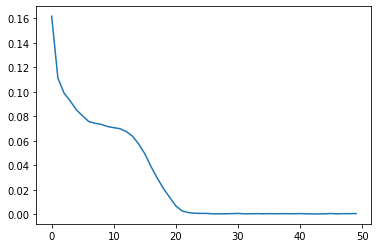

In [4]:
history = model.fit(train_dataset, train_dataset_label, epochs = 50, batch_size = 100)
plt.figure()

loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss)

(2000, 1)


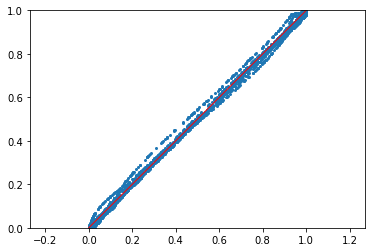

In [5]:
print(model.predict(test_dataset).shape)
# print(model.predict(test_dataset), test_dataset_label.shape)
plt.figure()
plt.plot([0,1], [0,1], 'r-', linewidth = 1)
plt.scatter(test_dataset_label, model.predict(test_dataset),s=4)
plt.axis('equal')
# plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# **Case II: FEM**
In this case, we apply the method to solve mechanical problems. The 2D model with a hole in the middle was stretched at the top surface while fixed at the bottom.

The part was meshed into 7303 elements. We extract the coordinates (x, y), displacements (ux, uy) and the strains (Exx, Eyy, Exy) at the nodal, which will be our raw data. We split those data into training (80%) and the elvaluation dataset (20%). Specically, we wish to build up a mapping function so that once the coordinate and displacement of the nodal are know if we can accurately predict strain, i.e.

Inputs/Dataset (x, y, ux, uy) --> Outputs/Label (Exx, Eyy, Exy)

FEM data can be obtained from Github: https://github.com/YuanQi-ME/hello-world/tree/master/Excercise2-FEM-data


![FEM_Schemetic](https://raw.githubusercontent.com/YuanQi-ME/hello-world/master/Excercise2-FEM-data/Model.PNG)


In [6]:
Coord0 = pd.read_csv('https://raw.githubusercontent.com/YuanQi-ME/hello-world/master/Excercise2-FEM-data/ANN_Coord0.csv',header=None)
Disp = pd.read_csv('https://raw.githubusercontent.com/YuanQi-ME/hello-world/master/Excercise2-FEM-data/ANN_Disp200.csv',header=None)
Strain = pd.read_csv('https://raw.githubusercontent.com/YuanQi-ME/hello-world/master/Excercise2-FEM-data/ANN_Strain200.csv',header=None)

In [7]:
dataset = pd.concat([Coord0, Disp, Strain], axis=1)
dataset.columns = range(len(dataset.columns))
print(dataset)

train_dataset = dataset.sample(frac=0.8, random_state=0)
train_dataset_label = train_dataset.drop([0,1,2,3], axis=1)
train_dataset = train_dataset.drop([4,5,6], axis=1)
train_dataset_label.columns = range(len(train_dataset_label.columns))
print(train_dataset, train_dataset_label)

test_dataset = dataset.drop(train_dataset.index)
test_dataset_label = test_dataset.drop([0,1,2,3], axis=1)
test_dataset = test_dataset.drop([4,5,6], axis=1)
test_dataset_label.columns = range(len(test_dataset_label.columns))
print(test_dataset, test_dataset_label)

x_data_items = 4
LAYERS_INFO = [128,128,128,64,3]
model_FEM = build_model(LAYERS_INFO)
model_FEM.summary()

             0         1         2         3         4         5         6
0    -0.237460 -0.078199  0.010701  0.038935 -0.018683  0.108310 -0.087867
1    -0.201080 -0.148550  0.008855  0.029070  0.009467  0.043329 -0.086154
2    -0.144520 -0.203990  0.006182  0.021431  0.005403  0.005472 -0.021009
3    -0.073463 -0.238960  0.003070  0.016699 -0.025308  0.005064  0.016109
4     0.004971 -0.249950 -0.000205  0.015230 -0.041311  0.010675 -0.001298
...        ...       ...       ...       ...       ...       ...       ...
7477 -0.306510  0.376700  0.003368  0.075616 -0.020540  0.050756  0.018529
7478 -0.314850  0.305120  0.004973  0.071467 -0.022580  0.055772  0.014659
7479  0.347970 -0.264330 -0.006788  0.032136 -0.022060  0.060500  0.005718
7480  0.238820  0.412530 -0.001663  0.079705 -0.015754  0.040774 -0.026739
7481 -0.335120  0.291190  0.005780  0.069909 -0.022386  0.058940  0.009188

[7482 rows x 7 columns]
            0         1             2             3
5024  0.56383 -0.465040

Epoch 1/50
60/60 [==============================] - 0s 3ms/step - loss: 1.8292e-04 - accuracy: 0.9222
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 6.6102e-05 - accuracy: 0.9581
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 4.2791e-05 - accuracy: 0.9664
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 3.3206e-05 - accuracy: 0.9688
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 2.4876e-05 - accuracy: 0.9703
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 1.9637e-05 - accuracy: 0.9729
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 1.6244e-05 - accuracy: 0.9736
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 1.3429e-05 - accuracy: 0.9729
Epoch 9/50
60/60 [==============================] - 0s 2ms/step - loss: 1.1434e-05 - accuracy: 0.9764
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 1.1484e-0

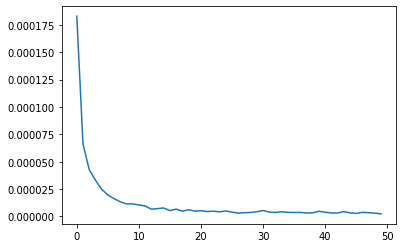

In [8]:
history_FEM = model_FEM.fit(train_dataset, train_dataset_label, epochs = 50, batch_size = 100)
plt.figure()

loss = history_FEM.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss)

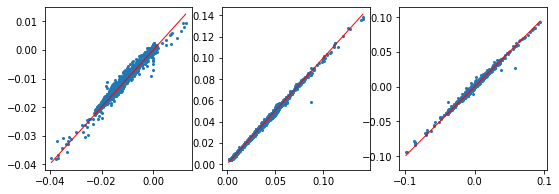

In [9]:
plt.figure(figsize=(9, 3))
plt.subplot(1,3,1)
plot_variable = test_dataset_label.loc[:, 0]
plt.plot([plot_variable.min(),plot_variable.max()], [plot_variable.min(),plot_variable.max()], 'r-', linewidth = 1)
plt.scatter(plot_variable, model_FEM.predict(test_dataset)[:,0],s=4)
plt.subplot(1,3,2)
plot_variable = test_dataset_label.loc[:, 1]
plt.plot([plot_variable.min(),plot_variable.max()], [plot_variable.min(),plot_variable.max()], 'r-', linewidth = 1)
plt.scatter(plot_variable, model_FEM.predict(test_dataset)[:,1],s=4)
plt.subplot(1,3,3)
plot_variable = test_dataset_label.loc[:, 2]
plt.plot([plot_variable.min(),plot_variable.max()], [plot_variable.min(),plot_variable.max()], 'r-', linewidth = 1)
plt.scatter(plot_variable, model_FEM.predict(test_dataset)[:,2],s=4)

plt.axis('equal')
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.show()

(-1.1, 1.1, -1.105, 1.205)

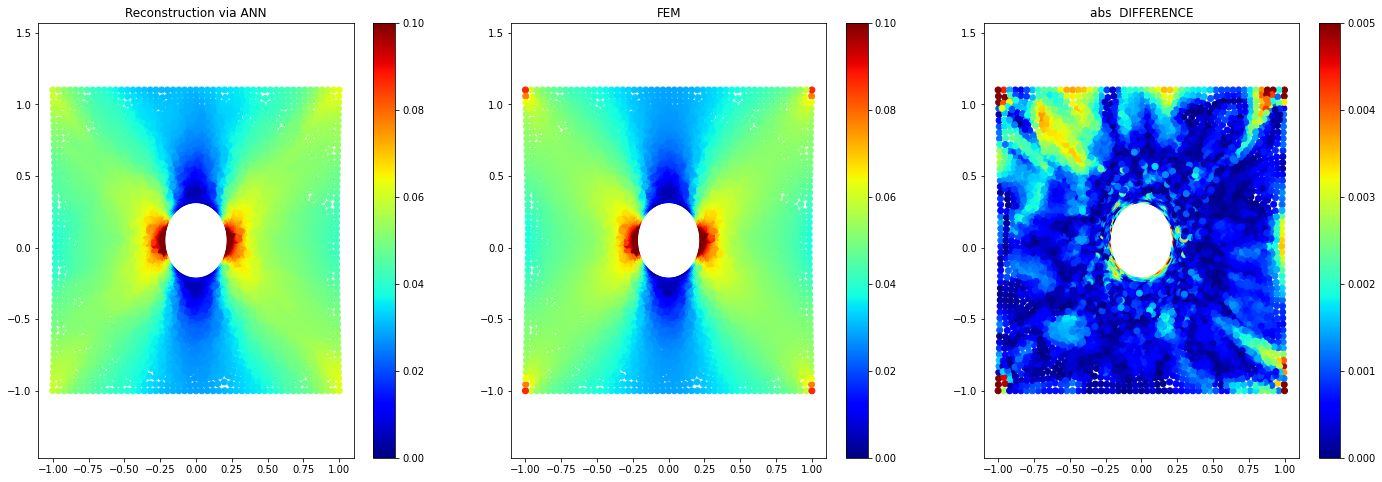

In [10]:
reconstruct = model_FEM.predict(dataset.drop([4,5,6], axis=1))
plt.figure(figsize=(24,8))
x_ = dataset.loc[:,0] + dataset.loc[:,2]
y_ = dataset.loc[:,1] + dataset.loc[:,3]

plt.subplot(1,3,1)
cp = plt.scatter(x_, y_, c=reconstruct[:,1],cmap="jet")
plt.clim(0, 0.1)
plt.colorbar(cp)
plt.title('Reconstruction via ANN')
plt.axis('equal')

plt.subplot(1,3,2)
cp = plt.scatter(x_, y_, c=dataset.loc[:,5],cmap="jet")
plt.clim(0, 0.1)
plt.colorbar(cp)
plt.title('FEM')
plt.axis('equal')

plt.subplot(1,3,3)
error_temp = (reconstruct[:,1]-dataset.loc[:,5])#/dataset.loc[:,5]
cp = plt.scatter(x_, y_, c=error_temp.abs(), cmap="jet")
plt.clim(0, 0.005)
plt.colorbar(cp)
plt.title('abs  DIFFERENCE')
plt.axis('equal')